In [1]:
from datasets import Dataset, DatasetDict
from datetime import datetime
import os

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import string
import re
from pickle import dump, load
from unicodedata import normalize

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
import spacy
import datasets
import torchtext
import tqdm
import evaluate

In [4]:
seed = 1234

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

### Dataset

In [5]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

In [6]:
# def readData(lang1, lang2):
#     print("Reading lines...")

#     # Read the file and split into lines
#     lines = open('../data/wiki/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
#         read().strip().split('\n')

#     # Split every line into pairs and normalize
#     pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

#     # Reverse pairs, make Lang instances
#     # if reverse:
#     #     pairs = [list(reversed(p)) for p in pairs]
#     #     input_lang = Lang(lang2)
#     #     output_lang = Lang(lang1)
#     # else:
#     #     input_lang = Lang(lang1)
#     #     output_lang = Lang(lang2)

#     data = [{lang1: pairs[0], lang2: pairs[1]}for pair in pairs]

#     return data

In [7]:
# data = readData('en', 'fr')

In [8]:
from lxml import etree

def tmx_to_tabbed_txt(tmx_file, output_file):
    """Extracts English and Hawaiian translations from a TMX file and saves them as tab-separated pairs."""
    
    # Define the XML namespace for `xml:lang`
    namespaces = {'xml': 'http://www.w3.org/XML/1998/namespace'}
    
    # Parse the TMX file
    xml_tree = etree.parse(tmx_file)
    trans_units = xml_tree.findall(".//tu")

    pairs = []
    
    # Open the output file for writing
    with open(output_file, "w", encoding="utf-8") as out_file:
        # Iterate over each translation unit
        for trans_unit in trans_units:
            pair = []
            source_text = trans_unit.find(".//tuv[@xml:lang='en']/seg", namespaces)
            target_text = trans_unit.find(".//tuv[@xml:lang='fr']/seg", namespaces)

            # Write the tab-separated pair if both texts are available
            if source_text is not None and target_text is not None and source_text.text and target_text.text:
                out_file.write(f"{source_text.text}\t{target_text.text}\n")
                pair.append(source_text.text)
                pair.append(target_text.text)
                pairs.append(pair)

    return pairs

if __name__ == "__main__":
    tmx_file = "../data/wiki/en-fr.tmx"
    output_file = "../data/wiki/en-fr.txt"
    pairs = tmx_to_tabbed_txt(tmx_file, output_file)

In [9]:
pairs = [[normalizeString(sentence) for sentence in pair] for pair in pairs]

In [10]:
len(pairs)

1365840

In [11]:
cleaned_pairs = [pair for pair in pairs if (len(pair[0]) > 0 and len(pair[0]) <= 41) and (len(pair[0]) > 0 and len(pair[0]) <= 41)]
len(cleaned_pairs)

137932

In [12]:
# Select the same amount of data with tatoeba
# tatoeba_size = 135842
# random.seed(1234)
# start_index = random.randint(0, len(pairs) - tatoeba_size)
# small_pairs = pairs[start_index:start_index + tatoeba_size]

In [13]:
# len(small_pairs)

In [14]:
# small_pairs[:10]

In [14]:
data = [{'en': pair[0], 'fr': pair[1]} for pair in cleaned_pairs]
data[:100]

[{'en': 'third stream', 'fr': 'le third stream'},
 {'en': 'gil evans influence', 'fr': 'l influence de gil evans'},
 {'en': 'the horn in the spotlight', 'fr': 'le cor sous les projecteurs'},
 {'en': 'contemporary horn in jazz', 'fr': 'le cor dans le jazz contemporain'},
 {'en': 'horn in jazz', 'fr': 'utilisateur djiboun le cor dans le jazz'},
 {'en': 'murder of jewish civil rights activists',
  'fr': 'meurtre de militants juifs des droits civiques'},
 {'en': 'questioning the golden age', 'fr': 'interrogations sur l age d or'},
 {'en': 'the problem was the condescending tone',
  'fr': 'le probleme etait le ton condescendant'},
 {'en': 'press of mississippi p lindemann albert s',
  'fr': 'black jewish relations on trial leo frank and jim conley in the new south univ'},
 {'en': 'edwards brent hayes', 'fr': 'note on the text'},
 {'en': 'note on the text the souls of black folk',
  'fr': 'the souls of black folk'},
 {'en': 'university of california press isbn p',
  'fr': 'blackface white no

In [16]:
random.seed(seed)
random.shuffle(data)

In [17]:
# splittng data
n = len(data)
n_train = int(0.8*n)
n_val = int(0.9*n)

train_data = data[:n_train]
val_data = data[n_train:n_val]
test_data = data[n_val:]

# convert to Huggingface dataset
train_dataset = Dataset.from_list(train_data)
val_dataset = Dataset.from_list(val_data)
test_dataset = Dataset.from_list(test_data)

# Create the DatasetDict
dataset_dict = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset,
    "test": test_dataset
})

In [18]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['en', 'fr'],
        num_rows: 110345
    })
    validation: Dataset({
        features: ['en', 'fr'],
        num_rows: 13793
    })
    test: Dataset({
        features: ['en', 'fr'],
        num_rows: 13794
    })
})

In [19]:
train_dataset[0]

{'en': 'main personal exhibitions',
 'fr': 'principales expositions personnelles'}

In [20]:
en_nlp = spacy.load("en_core_web_sm")
fr_nlp = spacy.load("fr_core_news_sm")

In [21]:
string = "What a lovely day it is today!"

[token.text for token in en_nlp.tokenizer(string)]

['What', 'a', 'lovely', 'day', 'it', 'is', 'today', '!']

In [22]:
def tokenize_example(example, en_nlp, fr_nlp, max_length, lower, sos_token, eos_token):
    en_tokens = [token.text for token in en_nlp.tokenizer(example["en"])][:max_length]
    fr_tokens = [token.text for token in fr_nlp.tokenizer(example["fr"])][:max_length]
    if lower:
        en_tokens = [token.lower() for token in en_tokens]
        fr_tokens = [token.lower() for token in fr_tokens]
    en_tokens = [sos_token] + en_tokens + [eos_token]
    fr_tokens = [sos_token] + fr_tokens + [eos_token]
    return {"en_tokens": en_tokens, "fr_tokens": fr_tokens}

In [23]:
max_length = 40
lower = True
sos_token = "<sos>"
eos_token = "<eos>"

fn_kwargs = {
    "en_nlp": en_nlp,
    "fr_nlp": fr_nlp,
    "max_length": max_length,
    "lower": lower,
    "sos_token": sos_token,
    "eos_token": eos_token,
}

train_dataset = train_dataset.map(tokenize_example, fn_kwargs=fn_kwargs)
val_dataset = val_dataset.map(tokenize_example, fn_kwargs=fn_kwargs)
test_dataset = test_dataset.map(tokenize_example, fn_kwargs=fn_kwargs)

Map:   0%|          | 0/110345 [00:00<?, ? examples/s]

Map:   0%|          | 0/13793 [00:00<?, ? examples/s]

Map:   0%|          | 0/13794 [00:00<?, ? examples/s]

In [24]:
train_dataset[0]

{'en': 'main personal exhibitions',
 'fr': 'principales expositions personnelles',
 'en_tokens': ['<sos>', 'main', 'personal', 'exhibitions', '<eos>'],
 'fr_tokens': ['<sos>', 'principales', 'expositions', 'personnelles', '<eos>']}

In [25]:
from torchtext.vocab import build_vocab_from_iterator
min_freq = 2
unk_token = "<unk>"
pad_token = "<pad>"

special_tokens = [
    unk_token,
    pad_token,
    sos_token,
    eos_token,
]

en_vocab = build_vocab_from_iterator(
    train_dataset["en_tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

fr_vocab = build_vocab_from_iterator(
    train_dataset["fr_tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [26]:
en_vocab.get_itos()[:10]

['<unk>', '<pad>', '<sos>', '<eos>', 'the', 'in', 'of', 'and', 'was', 'a']

In [27]:
fr_vocab.get_itos()[:10]

['<unk>', '<pad>', '<sos>', '<eos>', 'de', 'a', 'en', 'la', 'le', 'est']

In [28]:
en_vocab['the']

4

In [29]:
len(en_vocab), len(fr_vocab)

(22065, 27292)

In [30]:
assert en_vocab[unk_token] == fr_vocab[unk_token]
assert en_vocab[pad_token] == fr_vocab[pad_token]

unk_index = en_vocab[unk_token]
pad_index = en_vocab[pad_token]

In [31]:
en_vocab['The']

RuntimeError: Token The not found and default index is not set

In [32]:
en_vocab.set_default_index(unk_index)
fr_vocab.set_default_index(unk_index)

In [33]:
en_vocab['The']

0

In [34]:
en_vocab.get_itos()[0]

'<unk>'

In [35]:
tokens = ["i", "love", "watching", "crime", "shows"]
en_vocab.lookup_indices(tokens)

[44, 418, 11111, 2487, 621]

In [36]:
en_vocab.lookup_tokens(en_vocab.lookup_indices(tokens))

['i', 'love', 'watching', 'crime', 'shows']

In [37]:
def numericalize_example(example, en_vocab, fr_vocab):
    en_ids = en_vocab.lookup_indices(example["en_tokens"])
    fr_ids = fr_vocab.lookup_indices(example["fr_tokens"])
    return {"en_ids": en_ids, "fr_ids": fr_ids}

In [38]:
fn_kwargs = {"en_vocab": en_vocab, "fr_vocab": fr_vocab}

train_dataset = train_dataset.map(numericalize_example, fn_kwargs=fn_kwargs)
val_dataset = val_dataset.map(numericalize_example, fn_kwargs=fn_kwargs)
test_dataset = test_dataset.map(numericalize_example, fn_kwargs=fn_kwargs)

Map:   0%|          | 0/110345 [00:00<?, ? examples/s]

Map:   0%|          | 0/13793 [00:00<?, ? examples/s]

Map:   0%|          | 0/13794 [00:00<?, ? examples/s]

In [39]:
train_dataset[0]

{'en': 'main personal exhibitions',
 'fr': 'principales expositions personnelles',
 'en_tokens': ['<sos>', 'main', 'personal', 'exhibitions', '<eos>'],
 'fr_tokens': ['<sos>', 'principales', 'expositions', 'personnelles', '<eos>'],
 'en_ids': [2, 177, 200, 528, 3],
 'fr_ids': [2, 430, 476, 1903, 3]}

In [40]:
data_type = "torch"
format_columns = ["en_ids", "fr_ids"]

train_dataset = train_dataset.with_format(
    type=data_type, columns=format_columns, output_all_columns=True
)

val_dataset = val_dataset.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=True,
)

test_dataset = test_dataset.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=True,
)

In [41]:
train_dataset[0]

{'en_ids': tensor([  2, 177, 200, 528,   3]),
 'fr_ids': tensor([   2,  430,  476, 1903,    3]),
 'en': 'main personal exhibitions',
 'fr': 'principales expositions personnelles',
 'en_tokens': ['<sos>', 'main', 'personal', 'exhibitions', '<eos>'],
 'fr_tokens': ['<sos>', 'principales', 'expositions', 'personnelles', '<eos>']}

### Dataloaders

In [42]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_en_ids = [example["en_ids"] for example in batch]
        batch_fr_ids = [example["fr_ids"] for example in batch]
        en_lens = [example["en_ids"].shape[0] for example in batch]
        fr_lens = [example["fr_ids"].shape[0] for example in batch]
        batch_en_ids = nn.utils.rnn.pad_sequence(batch_en_ids, padding_value=pad_index)
        batch_fr_ids = nn.utils.rnn.pad_sequence(batch_fr_ids, padding_value=pad_index)
        batch = {
            "en_ids": batch_en_ids,
            "fr_ids": batch_fr_ids,
            "en_lens": en_lens,
            "fr_lens": fr_lens
        }
        return batch

    return collate_fn

In [43]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [44]:
batch_size = 128

train_data_loader = get_data_loader(train_dataset, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(val_dataset, batch_size, pad_index)
test_data_loader = get_data_loader(test_dataset, batch_size, pad_index)

In [45]:
len(valid_data_loader)

108

In [46]:
len(test_data_loader)

108

In [141]:
len(train_data_loader)

863

In [142]:
for batch in train_data_loader:
    print(batch)
    break

{'en_ids': tensor([[    2,     2,     2,  ...,     2,     2,     2],
        [ 3002,   188,    75,  ...,     0,     4,     9],
        [  147, 12607,     3,  ...,     3,  6418,  2337],
        ...,
        [    1,     1,     1,  ...,     1,     1,     1],
        [    1,     1,     1,  ...,     1,     1,     1],
        [    1,     1,     1,  ...,     1,     1,     1]]), 'fr_ids': tensor([[    2,     2,     2,  ...,     2,     2,     2],
        [24001,   441,    80,  ..., 18660,  2715,    20],
        [    3, 12172,   212,  ...,    11, 15423,   226],
        ...,
        [    1,     1,     1,  ...,     1,     1,     1],
        [    1,     1,     1,  ...,     1,     1,     1],
        [    1,     1,     1,  ...,     1,     1,     1]]), 'en_lens': [5, 4, 3, 5, 3, 3, 9, 3, 8, 9, 7, 5, 6, 7, 8, 4, 3, 3, 4, 11, 3, 8, 5, 8, 4, 7, 8, 5, 4, 6, 7, 7, 4, 6, 5, 7, 8, 6, 9, 8, 7, 4, 8, 5, 7, 3, 6, 4, 5, 5, 4, 6, 4, 9, 9, 7, 6, 9, 8, 6, 5, 9, 9, 12, 3, 8, 5, 4, 5, 4, 3, 4, 8, 3, 6, 4, 7, 4, 4, 11

### Model

In [48]:
class Encoder(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_lens):
        # src = [src length, batch size]
        embedded = self.dropout(self.embedding(src))
        # embedded = [src length, batch size, embedding dim]
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, np.array(src_lens), enforce_sorted=False, batch_first=False)
        packed_outputs, (hidden, cell) = self.rnn(packed)
        # outputs, (hidden, cell) = self.rnn(embedded)
        # outputs = [src length, batch size, hidden dim * n directions]
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        # outputs are always from the top hidden layer
        return hidden, cell

In [49]:
class Decoder(nn.Module):
    def __init__(self, output_dim, embedding_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(output_dim, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, cell):
        # input = [batch size]
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        # n directions in the decoder will both always be 1, therefore:
        # hidden = [n layers, batch size, hidden dim]
        # context = [n layers, batch size, hidden dim]
        input = input.unsqueeze(0)
        # input = [1, batch size]
        embedded = self.dropout(self.embedding(input))
        # embedded = [1, batch size, embedding dim]
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        # output = [seq length, batch size, hidden dim * n directions]
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        # seq length and n directions will always be 1 in this decoder, therefore:
        # output = [1, batch size, hidden dim]
        # hidden = [n layers, batch size, hidden dim]
        # cell = [n layers, batch size, hidden dim]
        prediction = self.fc_out(output.squeeze(0))
        # prediction = [batch size, output dim]
        return prediction, hidden, cell

In [50]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        assert (
            encoder.hidden_dim == decoder.hidden_dim
        ), "Hidden dimensions of encoder and decoder must be equal!"
        assert (
            encoder.n_layers == decoder.n_layers
        ), "Encoder and decoder must have equal number of layers!"

    def forward(self, src, src_lens, trg, trg_lens, teacher_forcing_ratio):
        # src = [src length, batch size]
        # trg = [trg length, batch size]
        # teacher_forcing_ratio is probability to use teacher forcing
        # e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        batch_size = trg.shape[1]
        trg_length = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        # tensor to store decoder outputs
        outputs = torch.zeros(trg_length, batch_size, trg_vocab_size).to(self.device)
        # last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src, src_lens)
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        # first input to the decoder is the <sos> tokens
        input = trg[0, :]
        # input = [batch size]
        for t in range(1, trg_length):
            # insert input token embedding, previous hidden and previous cell states
            # receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)
            # output = [batch size, output dim]
            # hidden = [n layers, batch size, hidden dim]
            # cell = [n layers, batch size, hidden dim]
            # place predictions in a tensor holding predictions for each token
            outputs[t] = output
            # decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            # get the highest predicted token from our predictions
            top1 = output.argmax(1)
            # if teacher forcing, use actual next token as next input
            # if not, use predicted token
            input = trg[t] if teacher_force else top1
            # input = [batch size]
        return outputs

### Training

In [51]:
input_dim = len(fr_vocab)
output_dim = len(en_vocab)
# the 2 embedding dims were 256 with tatoeba
encoder_embedding_dim = 512
decoder_embedding_dim = 512
hidden_dim = 512
# layer was 2 with tatoeba
n_layers = 4
encoder_dropout = 0.5
decoder_dropout = 0.5
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

encoder = Encoder(
    input_dim,
    encoder_embedding_dim,
    hidden_dim,
    n_layers,
    encoder_dropout,
)

decoder = Decoder(
    output_dim,
    decoder_embedding_dim,
    hidden_dim,
    n_layers,
    decoder_dropout,
)

model = Seq2Seq(encoder, decoder, device).to(device)

In [52]:
input_dim, output_dim

(27292, 22065)

In [53]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)


model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(27292, 512)
    (rnn): LSTM(512, 512, num_layers=4, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(22065, 512)
    (rnn): LSTM(512, 512, num_layers=4, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=22065, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [54]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 53,400,113 trainable parameters


In [55]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss(ignore_index=pad_index)
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [56]:
def train_fn(
    model, data_loader, optimizer, criterion, clip, teacher_forcing_ratio, device
):
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(data_loader):
        src = batch["fr_ids"].to(device)
        src_lens = batch["fr_lens"]
        trg = batch["en_ids"].to(device)
        trg_lens = batch["en_lens"]
        # src = [src length, batch size]
        # trg = [trg length, batch size]
        optimizer.zero_grad()
        output = model(src, src_lens, trg, trg_lens, teacher_forcing_ratio)
        # output = [trg length, batch size, trg vocab size]
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        # output = [(trg length - 1) * batch size, trg vocab size]
        trg = trg[1:].view(-1)
        # trg = [(trg length - 1) * batch size]
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        # scheduler.step()
        epoch_loss += loss.item()
    return epoch_loss / len(data_loader)

In [57]:
def evaluate_fn(model, data_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            src = batch["fr_ids"].to(device)
            src_lens = batch["fr_lens"]
            trg = batch["en_ids"].to(device)
            trg_lens = batch["en_lens"]
            # src = [src length, batch size]
            # trg = [trg length, batch size]
            output = model(src, src_lens, trg, trg_lens, 0)  # turn off teacher forcing
            # output = [trg length, batch size, trg vocab size]
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            # output = [(trg length - 1) * batch size, trg vocab size]
            trg = trg[1:].view(-1)
            # trg = [(trg length - 1) * batch size]
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    return epoch_loss / len(data_loader)

In [ ]:
n_epochs = 20
clip = 1.0
teacher_forcing_ratio = 0.5

best_valid_loss = float("inf")

date = datetime.today().strftime('%Y-%m-%d')
model_dir = f'../models/wiki/{date}'
# Create the directory
try:
    os.mkdir(model_dir)
    print(f"Directory '{model_dir}' created successfully.")
except FileExistsError:
    print(f"Directory '{model_dir}' already exists.")

train_lossi = []
val_lossi = []  

for epoch in tqdm.tqdm(range(n_epochs)):
    train_loss = train_fn(
        model,
        train_data_loader,
        optimizer,
        criterion,
        clip,
        teacher_forcing_ratio,
        device,
    )
    valid_loss = evaluate_fn(
        model,
        valid_data_loader,
        criterion,
        device,
    )

    train_lossi.append(train_loss)
    val_lossi.append(valid_loss)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), os.path.join(model_dir, f'mt_wiki_{train_loss:7.2f}_{valid_loss:7.2f}.pt'))
    print(f"\tTrain Loss: {train_loss:7.3f} | Train PPL: {np.exp(train_loss):7.3f}")
    print(f"\tValid Loss: {valid_loss:7.3f} | Valid PPL: {np.exp(valid_loss):7.3f}")

Directory '../models/wiki/2024-12-02' created successfully.


  5%|███▍                                                                | 1/20 [16:08<5:06:48, 968.87s/it]

	Train Loss:   6.326 | Train PPL: 558.728
	Valid Loss:   5.707 | Valid PPL: 301.117


 10%|██████▊                                                             | 2/20 [31:47<4:45:20, 951.13s/it]

	Train Loss:   5.847 | Train PPL: 346.039
	Valid Loss:   5.515 | Valid PPL: 248.363


 15%|██████████▏                                                         | 3/20 [47:32<4:28:38, 948.17s/it]

	Train Loss:   5.632 | Train PPL: 279.270
	Valid Loss:   5.339 | Valid PPL: 208.238


 20%|█████████████▏                                                    | 4/20 [1:03:11<4:11:55, 944.70s/it]

	Train Loss:   5.431 | Train PPL: 228.308
	Valid Loss:   5.203 | Valid PPL: 181.807


 25%|████████████████▌                                                 | 5/20 [1:19:32<3:59:27, 957.82s/it]

	Train Loss:   5.264 | Train PPL: 193.296
	Valid Loss:   5.087 | Valid PPL: 161.845


 30%|███████████████████▌                                             | 6/20 [1:37:57<3:55:10, 1007.93s/it]

	Train Loss:   5.122 | Train PPL: 167.732
	Valid Loss:   5.000 | Valid PPL: 148.451


 35%|██████████████████████▊                                          | 7/20 [1:58:44<3:55:19, 1086.10s/it]

	Train Loss:   4.996 | Train PPL: 147.828
	Valid Loss:   4.918 | Valid PPL: 136.786


 40%|██████████████████████████                                       | 8/20 [2:19:16<3:46:30, 1132.50s/it]

	Train Loss:   4.882 | Train PPL: 131.951
	Valid Loss:   4.857 | Valid PPL: 128.681


 45%|█████████████████████████████▎                                   | 9/20 [2:40:16<3:34:54, 1172.19s/it]

	Train Loss:   4.779 | Train PPL: 118.999
	Valid Loss:   4.803 | Valid PPL: 121.908


 50%|████████████████████████████████                                | 10/20 [3:01:36<3:20:56, 1205.68s/it]

	Train Loss:   4.680 | Train PPL: 107.717
	Valid Loss:   4.754 | Valid PPL: 116.055


 55%|███████████████████████████████████▏                            | 11/20 [3:23:12<3:04:57, 1233.06s/it]

	Train Loss:   4.587 | Train PPL:  98.163
	Valid Loss:   4.700 | Valid PPL: 109.994


 60%|██████████████████████████████████████▍                         | 12/20 [3:45:07<2:47:44, 1258.07s/it]

	Train Loss:   4.501 | Train PPL:  90.063
	Valid Loss:   4.658 | Valid PPL: 105.425


 65%|█████████████████████████████████████████▌                      | 13/20 [4:07:24<2:29:34, 1282.13s/it]

	Train Loss:   4.422 | Train PPL:  83.255
	Valid Loss:   4.625 | Valid PPL: 102.034


 70%|████████████████████████████████████████████▊                   | 14/20 [4:29:42<2:09:54, 1299.03s/it]

	Train Loss:   4.345 | Train PPL:  77.129
	Valid Loss:   4.594 | Valid PPL:  98.928


 75%|████████████████████████████████████████████████                | 15/20 [4:52:16<1:49:38, 1315.61s/it]

	Train Loss:   4.273 | Train PPL:  71.756
	Valid Loss:   4.560 | Valid PPL:  95.590


 80%|███████████████████████████████████████████████████▏            | 16/20 [5:15:03<1:28:43, 1330.99s/it]

	Train Loss:   4.201 | Train PPL:  66.759
	Valid Loss:   4.532 | Valid PPL:  92.935


 85%|██████████████████████████████████████████████████████▍         | 17/20 [5:38:22<1:07:34, 1351.38s/it]

	Train Loss:   4.136 | Train PPL:  62.533
	Valid Loss:   4.515 | Valid PPL:  91.374


In [60]:
# continue to train after it stopped randomly
model.load_state_dict(torch.load(os.path.join(f'../models/wiki/2024-12-02/', f'mt_wiki.pt')))

date = datetime.today().strftime('%Y-%m-%d')
model_dir = f'../models/wiki/{date}'
# Create the directory
try:
    os.mkdir(model_dir)
    print(f"Directory '{model_dir}' created successfully.")
except FileExistsError:
    print(f"Directory '{model_dir}' already exists.")

clip = 1.0
teacher_forcing_ratio = 0.5

best_valid_loss = float("inf")

train_lossi = []
val_lossi = []

for epoch in tqdm.tqdm(range(5)):
    train_loss = train_fn(
        model,
        train_data_loader,
        optimizer,
        criterion,
        clip,
        teacher_forcing_ratio,
        device,
    )
    valid_loss = evaluate_fn(
        model,
        valid_data_loader,
        criterion,
        device,
    )

    train_lossi.append(train_loss)
    val_lossi.append(valid_loss)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), os.path.join(model_dir, f'mt_wiki_{train_loss:7.2f}_{valid_loss:7.2f}.pt'))
    print(f"\tTrain Loss: {train_loss:7.3f} | Train PPL: {np.exp(train_loss):7.3f}")
    print(f"\tValid Loss: {valid_loss:7.3f} | Valid PPL: {np.exp(valid_loss):7.3f}")

Directory '../models/wiki/2024-12-03' already exists.


 20%|██████████████▏                                                        | 1/5 [06:01<24:07, 361.94s/it]

	Train Loss:   4.072 | Train PPL:  58.689
	Valid Loss:   4.498 | Valid PPL:  89.809


 40%|████████████████████████████▍                                          | 2/5 [12:17<18:29, 369.71s/it]

	Train Loss:   4.006 | Train PPL:  54.913
	Valid Loss:   4.483 | Valid PPL:  88.519


 60%|██████████████████████████████████████████▌                            | 3/5 [19:12<13:01, 390.76s/it]

	Train Loss:   3.941 | Train PPL:  51.459
	Valid Loss:   4.463 | Valid PPL:  86.729


 80%|████████████████████████████████████████████████████████▊              | 4/5 [26:41<06:53, 413.50s/it]

	Train Loss:   3.880 | Train PPL:  48.409
	Valid Loss:   4.447 | Valid PPL:  85.401


100%|███████████████████████████████████████████████████████████████████████| 5/5 [35:24<00:00, 424.95s/it]

	Train Loss:   3.823 | Train PPL:  45.733
	Valid Loss:   4.437 | Valid PPL:  84.522


In [66]:
print(train_lossi, val_lossi)

[4.072244177549766, 4.005741133474392, 3.9407816035446395, 3.879677883028846, 3.822822121037807] [4.497682178461993, 4.48321380438628, 4.462791590778916, 4.447352270285289, 4.4370116458998785]


In [69]:
train_lossi = []
val_lossi = []
for epoch in tqdm.tqdm(range(5)):
    train_loss = train_fn(
        model,
        train_data_loader,
        optimizer,
        criterion,
        clip,
        teacher_forcing_ratio,
        device,
    )
    valid_loss = evaluate_fn(
        model,
        valid_data_loader,
        criterion,
        device,
    )

    train_lossi.append(train_loss)
    val_lossi.append(valid_loss)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), os.path.join(model_dir, f'mt_wiki_{train_loss:7.2f}_{valid_loss:7.2f}.pt'))
    print(f"\tTrain Loss: {train_loss:7.3f} | Train PPL: {np.exp(train_loss):7.3f}")
    print(f"\tValid Loss: {valid_loss:7.3f} | Valid PPL: {np.exp(valid_loss):7.3f}")

 20%|██████████████▏                                                        | 1/5 [08:55<35:43, 535.91s/it]

	Train Loss:   3.767 | Train PPL:  43.247
	Valid Loss:   4.421 | Valid PPL:  83.155


 40%|████████████████████████████▍                                          | 2/5 [18:13<27:26, 548.92s/it]

	Train Loss:   3.713 | Train PPL:  40.990
	Valid Loss:   4.408 | Valid PPL:  82.116


 60%|██████████████████████████████████████████▌                            | 3/5 [27:57<18:49, 564.65s/it]

	Train Loss:   3.664 | Train PPL:  39.015
	Valid Loss:   4.396 | Valid PPL:  81.149


 80%|████████████████████████████████████████████████████████▊              | 4/5 [37:56<09:38, 578.43s/it]

	Train Loss:   3.613 | Train PPL:  37.060
	Valid Loss:   4.391 | Valid PPL:  80.687


100%|███████████████████████████████████████████████████████████████████████| 5/5 [48:47<00:00, 585.45s/it]

	Train Loss:   3.562 | Train PPL:  35.233
	Valid Loss:   4.383 | Valid PPL:  80.044


In [70]:
print(train_lossi, val_lossi)

[3.766921251148918, 3.7133240158284386, 3.6639441628859464, 3.612525670028368, 3.5619800737255005] [4.420706879209589, 4.408132712046306, 4.396289909327471, 4.390571625144394, 4.38258081012302]


In [59]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss(ignore_index=pad_index)
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

def train_fn(
    model, data_loader, optimizer, criterion, clip, teacher_forcing_ratio, device
):
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(data_loader):
        src = batch["fr_ids"].to(device)
        src_lens = batch["fr_lens"]
        trg = batch["en_ids"].to(device)
        trg_lens = batch["en_lens"]
        # src = [src length, batch size]
        # trg = [trg length, batch size]
        optimizer.zero_grad()
        output = model(src, src_lens, trg, trg_lens, teacher_forcing_ratio)
        # output = [trg length, batch size, trg vocab size]
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        # output = [(trg length - 1) * batch size, trg vocab size]
        trg = trg[1:].view(-1)
        # trg = [(trg length - 1) * batch size]
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        # scheduler.step()
        epoch_loss += loss.item()
    return epoch_loss / len(data_loader)

# continue to train after it stopped randomly
model.load_state_dict(torch.load(os.path.join(f'../models/wiki/2024-12-03/', f'mt_wiki.pt')))

date = datetime.today().strftime('%Y-%m-%d')
model_dir = f'../models/wiki/{date}'
# Create the directory
try:
    os.mkdir(model_dir)
    print(f"Directory '{model_dir}' created successfully.")
except FileExistsError:
    print(f"Directory '{model_dir}' already exists.")

clip = 1.0
teacher_forcing_ratio = 0.5

best_valid_loss = float("inf")

train_lossi = []
val_lossi = []

for epoch in tqdm.tqdm(range(10)):
    train_loss = train_fn(
        model,
        train_data_loader,
        optimizer,
        criterion,
        clip,
        teacher_forcing_ratio,
        device,
    )
    valid_loss = evaluate_fn(
        model,
        valid_data_loader,
        criterion,
        device,
    )

    train_lossi.append(train_loss)
    val_lossi.append(valid_loss)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), os.path.join(model_dir, f'mt_wiki_{train_loss:7.2f}_{valid_loss:7.2f}.pt'))
    print(f"\tTrain Loss: {train_loss:7.3f} | Train PPL: {np.exp(train_loss):7.3f}")
    print(f"\tValid Loss: {valid_loss:7.3f} | Valid PPL: {np.exp(valid_loss):7.3f}")

Directory '../models/wiki/2024-12-04' already exists.


 10%|███████                                                               | 1/10 [05:29<49:24, 329.44s/it]

	Train Loss:   3.649 | Train PPL:  38.424
	Valid Loss:   4.353 | Valid PPL:  77.683


 20%|██████████████                                                        | 2/10 [11:05<44:24, 333.10s/it]

	Train Loss:   3.501 | Train PPL:  33.141
	Valid Loss:   4.347 | Valid PPL:  77.243


 30%|█████████████████████                                                 | 3/10 [17:24<41:19, 354.26s/it]

	Train Loss:   3.436 | Train PPL:  31.068
	Valid Loss:   4.342 | Valid PPL:  76.838


 40%|████████████████████████████                                          | 4/10 [24:40<38:39, 386.56s/it]

	Train Loss:   3.376 | Train PPL:  29.249
	Valid Loss:   4.345 | Valid PPL:  77.123


 50%|███████████████████████████████████                                   | 5/10 [32:39<34:58, 419.69s/it]

	Train Loss:   3.321 | Train PPL:  27.682
	Valid Loss:   4.337 | Valid PPL:  76.497


 60%|██████████████████████████████████████████                            | 6/10 [41:16<30:11, 452.93s/it]

	Train Loss:   3.271 | Train PPL:  26.347
	Valid Loss:   4.344 | Valid PPL:  77.020


 70%|█████████████████████████████████████████████████                     | 7/10 [51:00<24:47, 495.73s/it]

	Train Loss:   3.224 | Train PPL:  25.131
	Valid Loss:   4.337 | Valid PPL:  76.501


 80%|██████████████████████████████████████████████████████▍             | 8/10 [1:01:00<17:37, 528.93s/it]

	Train Loss:   3.179 | Train PPL:  24.034
	Valid Loss:   4.342 | Valid PPL:  76.862


 90%|█████████████████████████████████████████████████████████████▏      | 9/10 [1:11:30<09:20, 560.44s/it]

	Train Loss:   3.139 | Train PPL:  23.083
	Valid Loss:   4.341 | Valid PPL:  76.763


100%|███████████████████████████████████████████████████████████████████| 10/10 [1:22:36<00:00, 495.61s/it]

	Train Loss:   3.096 | Train PPL:  22.118
	Valid Loss:   4.343 | Valid PPL:  76.971


In [60]:
print(train_lossi, val_lossi)

[3.6486871079525556, 3.5007742440299943, 3.4361804990337457, 3.3758538520764367, 3.3207758997986794, 3.2713455430049607, 3.2241062739494915, 3.17946598703864, 3.139100796654216, 3.096398694490364] [4.352634516027239, 4.346959209000623, 4.34169766638014, 4.345397894029264, 4.337253976751257, 4.344060911072625, 4.33730654142521, 4.342017317259753, 4.340727402104272, 4.343424470336349]


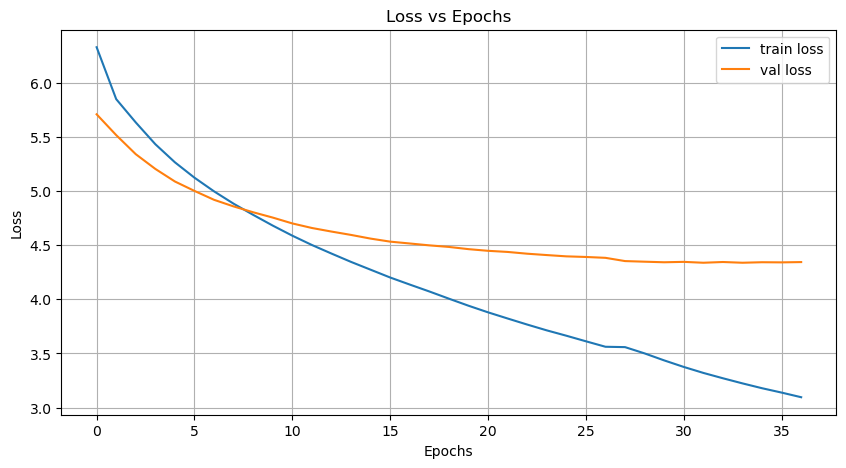

In [65]:
import matplotlib.pyplot as plt
train_loss_end = [6.326, 5.847, 5.632, 5.431, 5.264, 5.122, 4.996, 4.882, 4.779, 4.680, 4.587, 4.501, 4.422, 4.345, 4.273, 4.201, 4.136, 4.072244177549766,
                  4.005741133474392, 3.9407816035446395, 3.879677883028846, 3.822822121037807, 3.766921251148918, 3.7133240158284386, 3.6639441628859464, 3.612525670028368, 3.5619800737255005,
                 3.5586871079525556, 3.5007742440299943, 3.4361804990337457, 3.3758538520764367, 3.3207758997986794, 3.2713455430049607, 3.2241062739494915, 3.17946598703864, 3.139100796654216, 3.096398694490364]
train_ppl_end = [558.728, 346.039, 279.270, 228.308, 193.296, 167.732, 147.828, 131.951, 118.999, 107.717, 98.163, 90.063, 83.255, 77.129, 71.756, 66.759, 62.533
, 58.689, 54.913, 51.459, 48.409, 45.733, 43.247, 40.990, 39.015, 37.060, 35.233, 33.141, 31.068, 29.249, 27.682, 26.347, 25.131, 24.034, 23.083, 22.118]
val_loss_end = [5.707, 5.515, 5.339, 5.203, 5.087, 5.000, 4.918, 4.857, 4.803, 4.754, 4.700, 4.658, 4.625, 4.594, 4.560, 4.532, 4.515, 4.497682178461993,
                4.48321380438628, 4.462791590778916, 4.447352270285289, 4.4370116458998785, 4.420706879209589, 4.408132712046306, 4.396289909327471, 4.390571625144394, 4.38258081012302,
               4.352634516027239, 4.346959209000623, 4.34169766638014, 4.345397894029264, 4.337253976751257, 4.344060911072625, 4.33730654142521, 4.342017317259753, 4.340727402104272, 4.343424470336349]
val_ppl_end = [301.117, 248.363, 208.238, 181.807, 161.845, 148.451, 136.786, 128.681, 121.908, 116.055, 109.994, 105.425, 102.034, 98.928, 95.590, 92.935,
               91.374, 89.809, 88.519, 86.729, 85.401, 84.522, 83.155, 82.116, 81.149, 80.687, 80.044, 77.243, 76.838, 77.123
, 76.497, 77.020, 76.501, 76.862, 76.763, 76.971]

# train_loss_end += train_lossi
# val_loss_end += val_lossi
fig = plt.figure(figsize=(10,5))
plt.plot(train_loss_end, label='train loss')
plt.plot(val_loss_end, label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.grid()
plt.show()

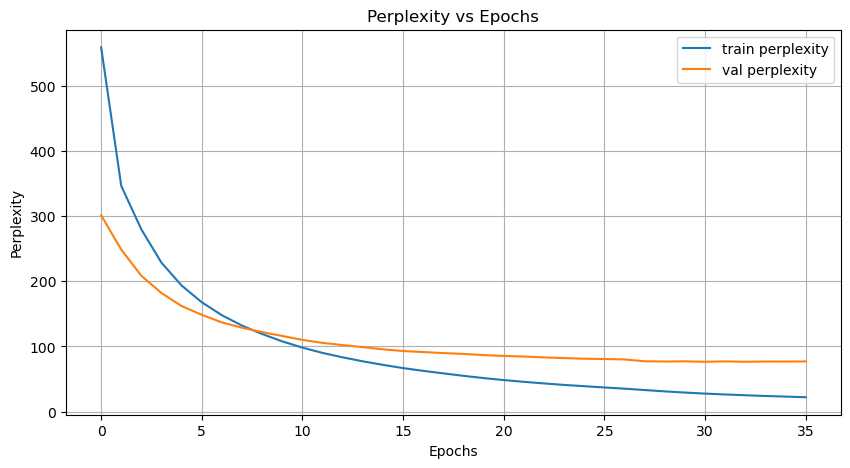

In [143]:
fig = plt.figure(figsize=(10,5))
plt.plot(train_ppl_end, label='train perplexity')
plt.plot(val_ppl_end, label='val perplexity')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.title('Perplexity vs Epochs')
plt.legend()
plt.grid()
plt.show()

### Evaluating on test set

In [135]:
model.load_state_dict(torch.load(os.path.join(f'../models/wiki/2024-12-04/', f'mt_wiki.pt')))

test_loss = evaluate_fn(model, test_data_loader, criterion, device)

print(f"| Test Loss: {test_loss:.3f} | Test PPL: {np.exp(test_loss):7.3f} |")

| Test Loss: 4.351 | Test PPL:  77.562 |


### BLEU score

In [136]:
def translate_sentence(
    sentence,
    model,
    en_nlp,
    fr_nlp,
    en_vocab,
    fr_vocab,
    lower,
    sos_token,
    eos_token,
    device,
    max_output_length=25,
):
    model.eval()
    with torch.no_grad():
        if isinstance(sentence, str):
            tokens = [token.text for token in fr_nlp.tokenizer(sentence)]
        else:
            tokens = [token for token in sentence]
        if lower:
            tokens = [token.lower() for token in tokens]
        tokens = [sos_token] + tokens + [eos_token]
        ids = fr_vocab.lookup_indices(tokens)
        tensor = torch.LongTensor(ids).unsqueeze(-1).to(device)
        src_len = [tensor.shape[0]]
        hidden, cell = model.encoder(tensor, src_len)
        inputs = en_vocab.lookup_indices([sos_token])
        for _ in range(max_output_length):
            inputs_tensor = torch.LongTensor([inputs[-1]]).to(device)
            output, hidden, cell = model.decoder(inputs_tensor, hidden, cell)
            predicted_token = output.argmax(-1).item()
            inputs.append(predicted_token)
            if predicted_token == en_vocab[eos_token]:
                break
        tokens = en_vocab.lookup_tokens(inputs)
    return tokens

In [84]:
sentence = test_data[10]["fr"]
expected_translation = test_data[10]["en"]

sentence, expected_translation

('il n a pas d enfants de l un ou l autre mariage',
 'there were no children of either marriage')

In [85]:
translation = translate_sentence(
    sentence,
    model,
    en_nlp,
    fr_nlp,
    en_vocab,
    fr_vocab,
    lower,
    sos_token,
    eos_token,
    device,
)

In [86]:
translation

['<sos>', 'there', 'were', 'no', 'children', 'of', 'his', 'marriage', '<eos>']

In [87]:
sentence = "Bonjour."

In [88]:
translation = translate_sentence(
    sentence,
    model,
    en_nlp,
    fr_nlp,
    en_vocab,
    fr_vocab,
    lower,
    sos_token,
    eos_token,
    device,
)

In [89]:
translation

['<sos>', '<unk>', '<unk>', '<eos>']

In [137]:
translations = [
    translate_sentence(
        example["fr"],
        model,
        en_nlp,
        fr_nlp,
        en_vocab,
        fr_vocab,
        lower,
        sos_token,
        eos_token,
        device,
    )
    for example in tqdm.tqdm(test_dataset)
]

100%|████████████████████████████████████████████████████████████████| 13794/13794 [03:35<00:00, 63.98it/s]


In [138]:
bleu = evaluate.load("bleu")

In [139]:
predictions = [" ".join(translation[1:-1]) for translation in translations]

references = [[example["en"]] for example in test_dataset]

In [144]:
for i in range(100):
    print(f'{predictions[i+100]}, {references[i+100]}, {tat_test_dataset[i+100]["fr"]}')

teams, ['staff'], cet endroit est parfait
george thomas thomas b, ['robert brydges b died young'], les deux generaux se rencontrerent de nouveau le lendemain
official website of website website, ['official website lgbtq video game archive'], ne soyez pas si durs avec vous memes
<unk> <unk>, ['extraterritorial jurisdiction'], tom est decede subitement
early life and career, ['life and career'], il vous faut me dire la verite
as featured artist, ['as writer'], vous ne voulez pas etre en retard a l entrainement
it is a tributary of the, ['he is a police superintendent'], veille a ton langage !
official website, ['official website'], ca doit etre une erreur
<unk> <unk> <unk>, ['behrens fisher problem'], elle se demanda ou elle avait perdu son sac a main
st <unk> of of <unk>, ['st rhode island volunteers at camp alger'], ne vous prenez pas tant au serieux !
second life, ['graduate school'], je deteste cette partie de la ville
modern, ['western countries'], comment peux tu etre aussi egoiste

In [94]:
test_dataset[0]

{'en_ids': tensor([  2, 111, 593,   3]),
 'fr_ids': tensor([   2, 5012, 2367,    3]),
 'en': 'national songs',
 'fr': 'musiques nationales',
 'en_tokens': ['<sos>', 'national', 'songs', '<eos>'],
 'fr_tokens': ['<sos>', 'musiques', 'nationales', '<eos>']}

In [95]:
def get_tokenizer_fn(nlp, lower):
    def tokenizer_fn(s):
        tokens = [token.text for token in nlp.tokenizer(s)]
        if lower:
            tokens = [token.lower() for token in tokens]
        return tokens

    return tokenizer_fn

In [96]:
tokenizer_fn = get_tokenizer_fn(en_nlp, lower)

In [97]:
tokenizer_fn(predictions[0]), tokenizer_fn(references[0][0])

(['music', 'music'], ['national', 'songs'])

In [98]:
results = bleu.compute(
    predictions=predictions, references=references, tokenizer=tokenizer_fn
)

In [99]:
results

{'bleu': 0.05915846536075221,
 'precisions': [0.2207334173736916,
  0.08079990142059958,
  0.03753607103218646,
  0.018295313983258062],
 'brevity_penalty': 1.0,
 'length_ratio': 1.2480510526967066,
 'translation_length': 70601,
 'reference_length': 56569}

### Cross testing with tatoeba test set

In [100]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

In [101]:
def readData(lang1, lang2):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('../data/tatoeba/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    # if reverse:
    #     pairs = [list(reversed(p)) for p in pairs]
    #     input_lang = Lang(lang2)
    #     output_lang = Lang(lang1)
    # else:
    #     input_lang = Lang(lang1)
    #     output_lang = Lang(lang2)

    data = [{lang1: pair[0], lang2: pair[1]}for pair in pairs]

    return data

In [102]:
tat_data = readData('en', 'fr')

Reading lines...


In [103]:
tat_data[:10]

[{'en': 'go', 'fr': 'va !'},
 {'en': 'run !', 'fr': 'cours !'},
 {'en': 'run !', 'fr': 'courez !'},
 {'en': 'wow !', 'fr': 'ca alors !'},
 {'en': 'fire !', 'fr': 'au feu !'},
 {'en': 'help !', 'fr': 'a l aide !'},
 {'en': 'jump', 'fr': 'saute'},
 {'en': 'stop !', 'fr': 'ca suffit !'},
 {'en': 'stop !', 'fr': 'stop !'},
 {'en': 'stop !', 'fr': 'arrete toi !'}]

In [104]:
random.seed(1234)
# print("Before shuffle:", data[:10])
random.shuffle(tat_data)
# print("After shuffle:", data[:10])
tat_data[:10]

[{'en': 'it s perfect', 'fr': 'c est parfait'},
 {'en': 'i was sitting next to a man who clearly had a lot on his mind',
  'fr': 'j etais assise a cote d un homme qui avait a l evidence de nombreuses choses en tete'},
 {'en': 'we have a gig at the club tomorrow night',
  'fr': 'nous faisons un b uf au club demain soir'},
 {'en': 'i m not going to hurt you', 'fr': 'je ne vais pas te faire de mal'},
 {'en': 'apart from a filing tray full of papers on the desk everything else in the room was on the floor',
  'fr': 'en dehors d une classeur plein de papiers sur le bureau tout le reste dans la piece etait par terre'},
 {'en': 'i d like to visit your country someday',
  'fr': 'j aimerais visiter ton pays un de ces jours'},
 {'en': 'how thoughtful of you to have chilled some wine for us',
  'fr': 'comme c est attentionne de votre part d avoir mis au frais du vin pour nous'},
 {'en': 'you should cut up your meat before you eat it',
  'fr': 'tu devrais couper ta viande en morceaux avant de la m

In [105]:
# splittng data
tat_n = len(tat_data)
tat_n_train = int(0.8*tat_n)
tat_n_val = int(0.9*tat_n)

tat_train_data = tat_data[:tat_n_train]
tat_val_data = tat_data[tat_n_train:tat_n_val]
tat_test_data = tat_data[tat_n_val:]

# convert to Huggingface dataset
tat_train_dataset = Dataset.from_list(tat_train_data)
tat_val_dataset = Dataset.from_list(tat_val_data)
tat_test_dataset = Dataset.from_list(tat_test_data)

# Create the DatasetDict
tat_dataset_dict = DatasetDict({
    "train": tat_train_dataset,
    "validation": tat_val_dataset,
    "test": tat_test_dataset
})

tat_dataset_dict

DatasetDict({
    train: Dataset({
        features: ['en', 'fr'],
        num_rows: 108673
    })
    validation: Dataset({
        features: ['en', 'fr'],
        num_rows: 13584
    })
    test: Dataset({
        features: ['en', 'fr'],
        num_rows: 13585
    })
})

In [106]:
tat_en_nlp = spacy.load("en_core_web_sm")
tat_fr_nlp = spacy.load("fr_core_news_sm")

In [107]:
string = "What a lovely day it is today!"

[token.text for token in tat_en_nlp.tokenizer(string)]

['What', 'a', 'lovely', 'day', 'it', 'is', 'today', '!']

In [108]:
def tokenize_example(example, en_nlp, fr_nlp, max_length, lower, sos_token, eos_token):
    en_tokens = [token.text for token in en_nlp.tokenizer(example["en"])][:max_length]
    fr_tokens = [token.text for token in fr_nlp.tokenizer(example["fr"])][:max_length]
    if lower:
        en_tokens = [token.lower() for token in en_tokens]
        fr_tokens = [token.lower() for token in fr_tokens]
    en_tokens = [sos_token] + en_tokens + [eos_token]
    fr_tokens = [sos_token] + fr_tokens + [eos_token]
    return {"en_tokens": en_tokens, "fr_tokens": fr_tokens}

In [109]:
max_length = 1_000
lower = True
sos_token = "<sos>"
eos_token = "<eos>"

fn_kwargs = {
    "en_nlp": tat_en_nlp,
    "fr_nlp": tat_fr_nlp,
    "max_length": max_length,
    "lower": lower,
    "sos_token": sos_token,
    "eos_token": eos_token,
}

tat_train_dataset = tat_train_dataset.map(tokenize_example, fn_kwargs=fn_kwargs)
tat_val_dataset = tat_val_dataset.map(tokenize_example, fn_kwargs=fn_kwargs)
tat_test_dataset = tat_test_dataset.map(tokenize_example, fn_kwargs=fn_kwargs)

Map:   0%|          | 0/108673 [00:00<?, ? examples/s]

Map:   0%|          | 0/13584 [00:00<?, ? examples/s]

Map:   0%|          | 0/13585 [00:00<?, ? examples/s]

In [110]:
tat_train_dataset[0]

{'en': 'it s perfect',
 'fr': 'c est parfait',
 'en_tokens': ['<sos>', 'it', 's', 'perfect', '<eos>'],
 'fr_tokens': ['<sos>', 'c', 'est', 'parfait', '<eos>']}

### BLEU score on tatoeba test set

In [111]:
translations = [
    translate_sentence(
        example["fr"],
        model,
        en_nlp,
        fr_nlp,
        en_vocab,
        fr_vocab,
        lower,
        sos_token,
        eos_token,
        device,
    )
    for example in tqdm.tqdm(tat_test_dataset)
]

100%|████████████████████████████████████████████████████████████████| 13585/13585 [04:27<00:00, 50.85it/s]


In [114]:
bleu = evaluate.load("bleu")

In [115]:
predictions = [" ".join(translation[1:-1]) for translation in translations]

references = [[example["en"]] for example in tat_test_dataset]

In [134]:
for i in range(100):
    print(f'{predictions[i]}, {references[i]}, {tat_test_dataset[i]["fr"]}')

each the the the the, ['keep your hands on the wheel'], laissez les mains sur le volant
his powerband was be be be, ['his teacher should be strict with him'], son professeur devrait etre strict avec lui
what is t ? ? ? ?, ['what s kept you ?'], qu est ce qui t a retenu ?
i don t t t that, ['i don t know who did it'], je ne sais pas qui l a fait
i don t it, ['i make you nervous don t i ?'], je te rends nerveux n est ce pas ?
i didn t have the the, ['i don t have the slightest clue'], je n en ai pas la moindre idee
i don t t t that i, ['i don t know what i m doing yet'], je ne sais pas encore ce que je fais
go you to you ? ?, ['do you want to dance with me ?'], veux tu danser avec moi ?
this is not the the of, ['size does not matter'], ce n est pas la taille qui compte
i have to to the, ['i ve heard all about you'], j ai tout entendu a ton sujet
the <unk> <unk> is is m to metres, ['the food at that restaurant is too greasy for me'], le menu de ce restaurant est trop gras pour moi
there a

In [119]:
tat_test_dataset[0]

{'en': 'keep your hands on the wheel',
 'fr': 'laissez les mains sur le volant',
 'en_tokens': ['<sos>',
  'keep',
  'your',
  'hands',
  'on',
  'the',
  'wheel',
  '<eos>'],
 'fr_tokens': ['<sos>',
  'laissez',
  'les',
  'mains',
  'sur',
  'le',
  'volant',
  '<eos>']}

In [120]:
def get_tokenizer_fn(nlp, lower):
    def tokenizer_fn(s):
        tokens = [token.text for token in nlp.tokenizer(s)]
        if lower:
            tokens = [token.lower() for token in tokens]
        return tokens

    return tokenizer_fn

In [121]:
tokenizer_fn = get_tokenizer_fn(en_nlp, lower)

In [122]:
tokenizer_fn(predictions[0]), tokenizer_fn(references[0][0])

(['each', 'the', 'the', 'the', 'the'],
 ['keep', 'your', 'hands', 'on', 'the', 'wheel'])

In [123]:
results = bleu.compute(
    predictions=predictions, references=references, tokenizer=tokenizer_fn
)
results

{'bleu': 0.011675776571236252,
 'precisions': [0.2445362299986991,
  0.029952071600198325,
  0.006236942362049896,
  0.0004068190623789229],
 'brevity_penalty': 1.0,
 'length_ratio': 1.0131581837752346,
 'translation_length': 92244,
 'reference_length': 91046}